In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import e
import scipy
from cycler import cycler

plt.style.use('ggplot')

np.random.seed(42)
%matplotlib inline

In this notebook, we're going to explore a few different concepts:

1. Differential Privacy using the Laplace Mechanism: a way to sample "intelligent" noise (e.g. error) and insert it into the results to reduce privacy loss.

2. Composition: or the ability to combine differentially private responses to reason about privacy loss (or information gain, depending on how you look at it!).

3. How we can calculate a privacy budget using the above concepts! A privacy budget (or privacy accountant) allows us to limit the amount of privacy loss for an individual over the course of several queries.

To do so, we will first create an artificial dataset of ages and salaries.

In [2]:
mid_level_age = 45
mid_level_salary = 50000

age_scale = 10 #scale represents one standard deviation
salary_scale = 10000

salaries = [round(np.random.normal(mid_level_salary,salary_scale)) for _ in range(100)]
ages = [round(np.random.normal(mid_level_age,age_scale)) for _ in range(100)]

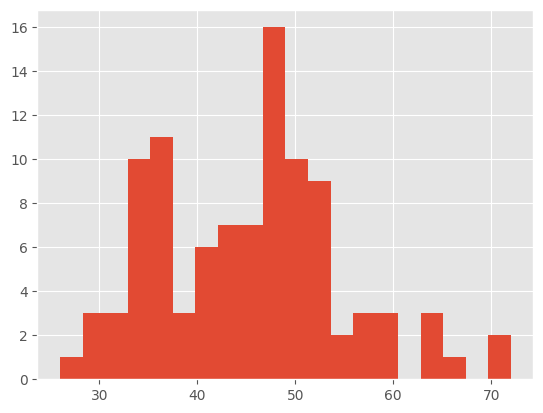

In [3]:
plt.hist(ages, bins=20);

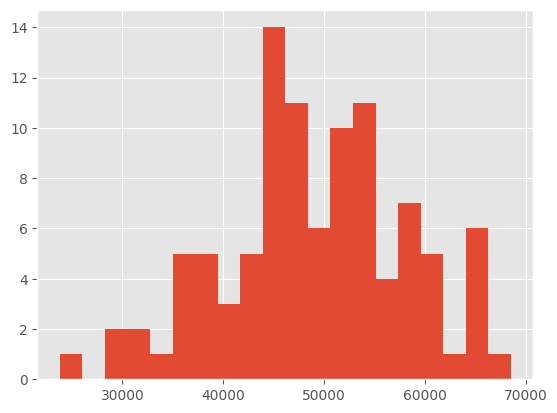

In [4]:
plt.hist(salaries, bins=20);

### What is Differential Privacy?

[Differential Privacy](https://desfontain.es/privacy/friendly-intro-to-differential-privacy.html) is a theory and technology used to better use and release data in a privacy-respecting way. It is a rigorous method to measure how much information any individual will leak when they contribute to a piece of data, statistic or even a machine learning model. By measuring and controlling the individual contribution, we can create rigorous definitions and guarantees that support individual privacy. 

We can tune this on a case-by-case basis and we can create a technical and data strategy around how we share this data in different contexts (i.e. more privacy for public releases, less privacy/more information for need-to-know internal use cases).

To explain it a different way, differential privacy helps us *obfuscate* information from individuals in the dataset without completely destroying the statistical properties of the data. We do so by controlling how much information a person can contribute and by carefully adding controlled noise, to allow for uncertainty in drawing specific conclusions about individuals.

To explore how this might work, we will start by understanding differential privacy using our dataset and the Laplace mechanism!

### Laplace Mechanism

Let's take a look at the Laplace mechanism and notice the properties it gives us. Our goal in evaluating Laplace is to understand, what can it offer in terms of providing controlled noise, and therefore, uncertainty in our results, so that it is less clear to a potential observer, who *exactly* is in our dataset and what attributes this person has (here, age and salary).

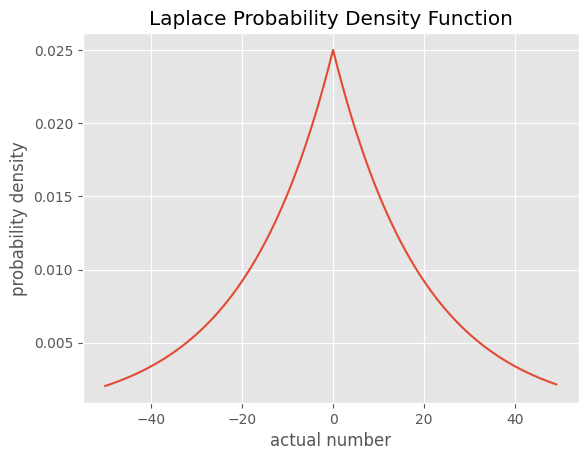

In [5]:
loc = 0
scale = 20

x = np.arange(-50., 50., 1)
pdf = np.exp(-abs(x-loc)/scale)/(2.*scale)

fig,ax= plt.subplots()
ax.plot(x, pdf, linestyle='-');
ax.set_title('Laplace Probability Density Function')
ax.set_xlabel('actual number')
ax.set_ylabel('probability density');

Depending on the Mu and b values, we can see how the distribution changes, and how this might then affect our results.

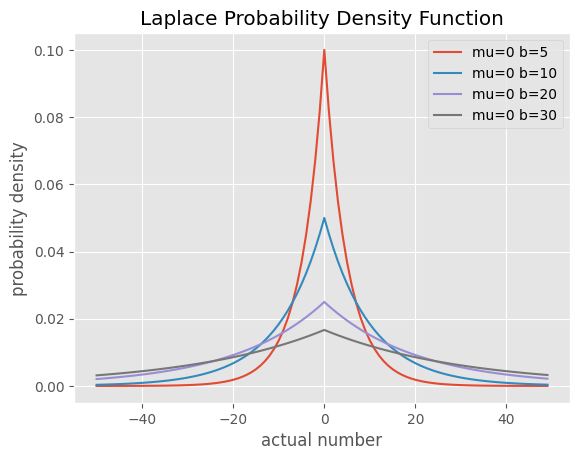

In [6]:
mu = [0, 0, 0, 0]
b = [5, 10, 20, 30]
linestyle_cycler = cycler('linestyle',['-','--',':','-.'])

x = np.arange(-50., 50., 1)
fig,ax= plt.subplots()
plt.rc('axes', prop_cycle=linestyle_cycler)

for mu_val, b_val in zip(mu, b):
    pdf = np.exp(-abs(x-mu_val)/b_val)/(2.*b_val)
    ax.plot(x, pdf, label='mu=%s b=%s' % (mu_val, b_val))
    
ax.set_title('Laplace Probability Density Function')
ax.set_xlabel('actual number')
ax.set_ylabel('probability density')
ax.set_prop_cycle(linestyle_cycler)
ax.legend()

## Making a "Differential Privacy Mechanism"

You might have heard the term "differential privacy mechanism". This is a way to take data and to provide a "differential privacy guarantee" by controlling the contribution and the noise before releasing the data for further analysis.

Let's create a very naive differential privacy mechanism, that samples from Laplace and adds the noise to the result. Please note, do not use this with any real data! Instead use a well-known and audited open-source library!

NOTE: this is an incorrect usage of laplace, please do not use in a real problem! 

In [7]:
epsilon = 1.1

def naive_laplace_dp_mechanism(value, epsilon):
    # Please do not use this function, ever :)
    orig_value = value
    value =  np.random.laplace(value, 1/epsilon) # more on this choice of 1/epsilon later!
    print("Noise: {}".format(value - orig_value))
    return value

Now let's calculate a summary statistic and see the result. I'll start with a mean of the ages.

In [8]:
naive_laplace_dp_mechanism(np.mean(ages), epsilon)

Noise: 1.277692233946226


46.55769223394623

In [9]:
np.mean(ages)

45.28

And what if you added an outlier?

In [10]:
naive_laplace_dp_mechanism(np.mean(ages + [110]), epsilon)

Noise: 0.5971700616306563


46.51796214083858

In [11]:
naive_laplace_dp_mechanism(np.mean(ages + [1]), epsilon)

Noise: 0.45538840431066063


45.2969725627265

## Exercise:

Try it out with salaries. What is similar or different? And what about if you looked at something like mode, or min, or max?


It seems here that the mean result for ages and salaries is unsafe.... What did we do wrong?


Let's take a look at the "noise" we are adding.

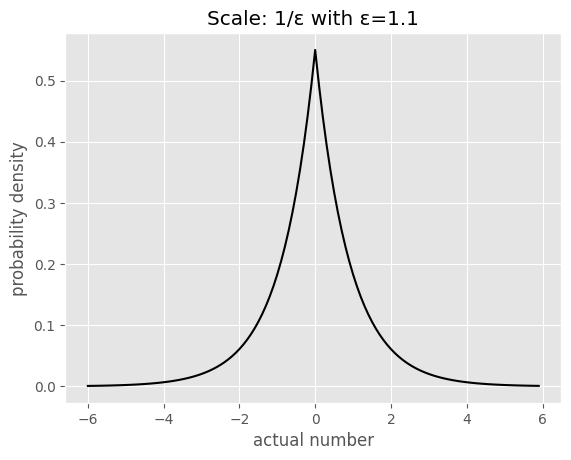

In [12]:
loc = 0
scale = 1/1.1

x = np.arange(-6., 6., .1)
pdf = np.exp(-abs(x-loc)/scale)/(2.*scale)

fig,ax= plt.subplots()
ax.plot(x, pdf, label='mu=%s b=%s' % (loc, scale), linestyle='-')
ax.set_title('Scale: 1/ε with ε=1.1')
ax.set_xlabel('actual number')
ax.set_ylabel('probability density');

In order to figure out how to safely add noise, we need to better understand sensitivity!

### Exploring Sensitivity and Error

When we want to release data in a differentially privacy way, we need to think about the sensitivity of the result. This is how much one person can change the result of a query. 

Our error / noise insertion needs to scale with this sensitivity in order for the differential privacy guarantee to hold (i.e. that with one addition or removal to the data, I cannot get "too much" more information based on the query result).

Sensitivity is how much one person (or privacy unit) can change the results. As you can see, we've been using sensitivity improperly! Let's choose something that is easy to define. 

First, we can rewrite our mean as a SUM over a COUNT. 

We know that for SUM, the maximum one person can change the result is by + or - 1.

In [13]:
new_ages = ages + [round(np.random.normal(mid_level_age, age_scale))]

In [14]:
len(new_ages) - len(ages)

1

Now our sensitivity is correct for our counting query!

But what about our SUM query?

If we want to use bounds in order to bound a previously *unbounded query*, such as a SUM, we can do so by determining those bounds and then enforcing those bounds on our existing and incoming data. 

Since I know this dataset is employees who are working, I can choose bounds of 20-70 for the ages. 

In [15]:
def filter_bounds(value, lower_bound, upper_bound):
    if value < lower_bound:
        return lower_bound
    elif value > upper_bound:
        return upper_bound
    return value

In [ ]:
# %load solutions/filter_bounds.py

In [16]:
bounded_ages = [filter_bounds(age, 20, 70) for age in ages]

Now that we have bounded the amount that one person can contribute to a sensitivity of 50, we can appropriately scale the noise, so that we can calculate a safe sum. But first we need to figure out how we can run multiple queries and still keep the same guarantees!

Remember, we use differential privacy so we can guarantee every individual some amount of privacy, no matter who they are and how much they are different than the others. As you can see, our bounding helps with that! But it also means when we increase the sensitivity - we also increase the carefully constructed noise. 

And, so far we've only measured sensitivity for ONE query at a time. When we want to run multiple queries (like a SUM and a COUNT), we need to track the privacy loss of those individuals for each query and make sure we know how much privacy loss they can expect in total. This is brings us to...

### Composition

So how do we reason about how much privacy loss there is when we answer a series of questions about the data? Differential privacy promises that we can track and measure privacy loss, so how do we do this?

One amazing property of differential privacy is that the epsilon value (ε) is our privacy loss for one particular response and it has the property of being individual to each query and yet composable -- meaning if I answer two queries, I can add their epsilons to calculate the privacy loss!

What does this mean in practice? 

1. Privacy budgets! I can budget my total epsilon appropriately over the course of a certain amount of queries. This means I can detemine how much information gain / privacy loss someone has when given multiple queries across the data.

2. The privacy loss is only for the individuals contained in the query response. This means I could also count the budget per individual and stop including those individuals in the responses once their budget has been reached. Of course, this will likely than bias my data as more individuals "drop out" when their budgets are reached.

3. Depending on what epsilon I come up with, I may want to spend more of it on a particular query than others. So if I know the queries in advance or if I am releasing data all at once, I may want to allocate my budget on a query by query basis!

Let's now fix our differential privacy mechanism. It should be similar to the one above, but this time take sensitivity as a parameter. We scale Laplace by sensitivity / epsilon!

In [17]:
# Write a new laplace_dp_mechanism that takes the value, the epsilon and sensitivity as a keyword argument.
# See usage below. If you'd like, you can add the print statement to observe the mechanism as you learn, but 
# in real life you'd never ever know the noise as it would immediately violate the guarantee!

# Also please never write your own DP mechanism, use a trusted library that has been tested and audited. :)

In [ ]:
# %load solutions/laplace_dp.py


In [17]:
def laplace_dp_mechanism(value, epsilon, sensitivity=1):
    orig_value = value
    value =  np.random.laplace(value, sensitivity/epsilon) # now you see why the 1 was a poor choice!
    print("Noise: {}".format(value - orig_value))
    return value


In [18]:
epsilon_for_sum = 0.5
epsilon_for_count = 0.5

summed_ages = laplace_dp_mechanism(np.sum(bounded_ages), epsilon_for_sum, sensitivity=50)
count_ages = laplace_dp_mechanism(len(bounded_ages), epsilon_for_count, sensitivity=1)

average_age = summed_ages / count_ages

Noise: -53.24175804583501
Noise: 1.928454653399541


In [19]:
average_age

43.88135047434459

which means a relative error of...

In [20]:
(average_age - np.mean(ages))/ np.mean(ages)

-0.030888902951753706

![High Five](https://media.giphy.com/media/ujGfBmVppmgEg/giphy.gif "Liz Lemon gives herself a high-five to celebrate and so should you!")

You did it! You built your first DP mechanism!

Of course, this mechanism is really only a toy example to get you learning, please don't use it in production! I hope, however, that it has peaked your interest in learning more about differential privacy and privacy technologies! You can also check out a few other notebooks in this repository to learn more and read the References!

### Homework

So far we've investigated the ages dataset. Try answering some basic questions about the salaries dataset using the (very simple and slightly broken) Laplace mechanism we've defined here. Some starting points might be:

- What is the average salary? 
- What is the average salary of people over 40?
- What is the average salary for people under 40?

To do so, you might first want to link the datasets. I have written some example code below to help you get started! 

_Note_: When you are first experimenting with differential privacy mechanisms and real data, you might end up using the budget just trying to figure out how you might want to release the data. This is not optimal, but it is necessary. The most essential task is to get the differential privacy mechanisms used working properly before releasing data outside of your organization or across trust boundaries.

In [21]:
my_budget = 1.1

# Try tracking your budget as you answer the above. Think about how you spend it wisely!!! 

In [22]:
linked_dataset = np.column_stack((ages, salaries))

In [23]:
over_40 = linked_dataset[(linked_dataset[:,0] > 40)]

In [24]:
num_employees_over_40 = laplace_dp_mechanism(len(over_40[:,1]), 0.3, sensitivity=1)
num_employees_over_40

Noise: 3.22727006175694


71.22727006175694

In [25]:
len(over_40[:,1])

68

In [26]:
#keeping my budget honest!
my_budget -= 0.3

In [27]:
my_budget

0.8

In [40]:
average_salary_no_dp = np.mean(salaries)
average_salary_no_dp

48961.53

In [41]:
#With noise
epsilon_for_salary_sum = 0.5
epsilon_for_salary_count = 0.5

summed_salaries = laplace_dp_mechanism(np.sum(salaries), epsilon_for_salary_sum, sensitivity=50)

count_salaries = laplace_dp_mechanism(len(salaries), epsilon_for_salary_count, sensitivity=1)

average_salary = summed_salaries / count_salaries

average_salary




Noise: 28.207243809476495
Noise: -3.535754701852156


50756.4351134546

In [49]:
# Filter the salaries of employees over 40, no noise
ages = np.array(ages)
salaries = np.array(salaries)
salaries_over_40_no_dp = salaries[ages >= 40]

average_salary_over_40_no_dp = np.mean(salaries_over_40_no_dp)
average_salary_over_40_no_dp

48168.07246376811

In [47]:
# Filter the salaries of employees under 40, no noise
ages = np.array(ages)
salaries = np.array(salaries)
salaries_under_40_no_dp = salaries[ages < 40]

average_salary_under_40_no_dp = np.mean(salaries_under_40_no_dp)
average_salary_under_40_no_dp

50727.6129032258

In [35]:
# Get the salaries of employees over 40 with noise
salaries_over_40 = over_40[:, 1]

epsilon_for_salary_sum_over_40 = 0.5
epsilon_for_salary_count_over_40 = 0.5

summed_salaries_over_40 = laplace_dp_mechanism(np.sum(salaries_over_40), epsilon_for_salary_sum_over_40, sensitivity=50)

count_salaries_over_40 = laplace_dp_mechanism(len(salaries_over_40), epsilon_for_salary_count_over_40, sensitivity=1)

average_salary_over_40 = summed_salaries_over_40 / count_salaries_over_40

average_salary_over_40

Noise: -55.67255861451849
Noise: 0.4009706991724613


47900.75775168824

In [38]:
# Get the salaries of employees under 40
salaries_under_40 = linked_dataset[(linked_dataset[:, 0] <= 40), 1]

epsilon_for_salary_sum_under_40 = 0.5
epsilon_for_salary_count_under_40 = 0.5

summed_salaries_under_40 = laplace_dp_mechanism(np.sum(salaries_under_40), epsilon_for_salary_sum_under_40, sensitivity=50)

count_salaries_under_40 = laplace_dp_mechanism(len(salaries_under_40), epsilon_for_salary_count_under_40, sensitivity=1)

average_salary_under_40 = summed_salaries_under_40 / count_salaries_under_40

average_salary_under_40

Noise: -136.9944647869561
Noise: 0.0910128154381411


50465.905044795385

### Recommended Reading

- Ted on Privacy's Blog Series on Differential Privacy! https://desfontain.es/privacy/friendly-intro-to-differential-privacy.html

## Appendix

Below is a recreation of a graph by Damien Desfontaines in Python, to show the probability bounds of different choices of epsilon, to give you a visual idea of the privacy loss and attacker's information gain.

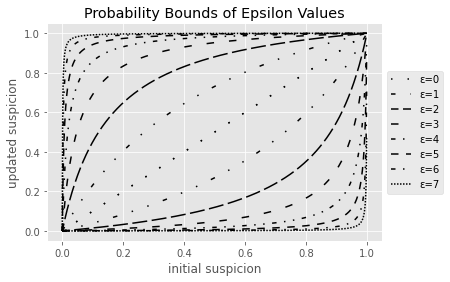

In [25]:
fig, ax = plt.subplots(1)

y = np.arange(0, 1.0, 0.001)
x = np.arange(0, 1.0, 0.001)


linestyle_tuple = [
     ('loosely dotted',        (0, (1, 10))),
     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('long dash with offset', (5, (10, 3))),
     ('loosely dashed',        (0, (5, 10))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('dashed',                (0, (5, 5))),
     ('dashdotted',            (0, (3, 5, 1, 5))),
     ('dotted',                (0, (1, 1))),
]

for epsilon in range(8):
    lower_bounds = (e**epsilon * y) / \
         (1 + (e**epsilon - 1)  * y)
    upper_bounds = y / (e**epsilon + (1-e**epsilon) * y)

    ax.plot(x, upper_bounds, label='ε={}'.format(epsilon), 
            linestyle=linestyle_tuple[epsilon][1])
    ax.plot(x, lower_bounds, linestyle=linestyle_tuple[epsilon][1])

ax.set_title('Probability Bounds of Epsilon Values')
ax.set_xlabel('initial suspicion')
ax.set_ylabel('updated suspicion')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))